In [ ]:
# importing required libraries
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re
from keras.optimizers import Adam
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the dataset
data_train = pd.read_csv("/content/drive/MyDrive/fake-news/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("/content/drive/MyDrive/fake-news/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("/content/drive/MyDrive/fake-news/test.tsv", sep="\t", header=None)
data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]] 
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  
  dataset["sentence"] = dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [ ]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train = data_preprocessing(data_train)
data_valid = data_preprocessing(data_valid)
data_test = data_preprocessing(data_test)

In [ ]:
#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,Says the Annies List political group supports ...
1,0,When did the decline of coal start? It started...
2,1,"Hillary Clinton agrees with John McCain ""by vo..."
3,0,Health care reform legislation is likely to ma...
4,0,The economic turnaround started at the end of ...


In [ ]:
# maximun length of a sentence in the corpus
max_len_train = (data_train['sentence'].apply(lambda x: len(x.split(' ')))).max()
print('Max length of a sentence in the corpus: ' + str(max_len_train))

Max length of a sentence in the corpus: 302


In [ ]:
# maximun length of a sentence in the corpus
max_len_test = (data_test['sentence'].apply(lambda x: len(x.split(' ')))).max()
print('Max length of a sentence in the corpus: ' + str(max_len_test))

Max length of a sentence in the corpus: 283


In [ ]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train.sentence)
X1 = tokenizer.texts_to_sequences(data_train.sentence.values)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# padding sequences with zeroes
X1 = pad_sequences(X1, padding = 'post', maxlen = max_len_train)

# one hot encoding the labels
y1 = to_categorical(data_train.label)

In [ ]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_test.sentence)
X2 = tokenizer.texts_to_sequences(data_test.sentence.values)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# padding sequences with zeroes
X2 = pad_sequences(X2, padding = 'post', maxlen = max_len_train)

# one hot encoding the labels
y2 = to_categorical(data_test.label)

In [ ]:
X_train = X1
y_train = y1
X_test = X2
y_test = y2
print("Size of Training data: " + str(len(X_train)))
print("Size of Testing data: " + str(len(X_test)))

Size of Training data: 10240
Size of Testing data: 1267


In [ ]:
#importing required libraries
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# for generating word2vec embeddings
tokenized_text = [simple_preprocess(text, deacc=True) for text in data_train.sentence]

# CBOW model (sg = 0)
# Embedding Dimensions
size = 300
# Context Window
window = 6
# Min count of words
min_count = 1
# CBOW
sg = 0

# # for gensim 4.x
# w2v_model = Word2Vec(tokenized_text, vector_size = size, window = window, min_count = min_count, sg = sg)

# for gensim 3.x
w2v_model = Word2Vec(tokenized_text, size = size, window = window, min_count = min_count, sg = sg)

word2vec_model_file = 'word2vec_cbow_' + str(window) + '_' + str(size) + '.model'
w2v_model.save(word2vec_model_file)

In [ ]:
word2vec_model_file

'word2vec_cbow_6_300.model'

In [ ]:
# loading word2vec cbow embeddings

model_cbow = KeyedVectors.load('/content/word2vec_cbow_6_300.model')

In [ ]:
# embedding index

embeddings_index = {}

#for gensim 4.x
#for w in (model_cbow.wv.key_to_index).keys():
    #embeddings_index[w] = model_cbow.wv[w]
    
#for gensim 3.x
for w in model_cbow.wv.vocab.keys():
    embeddings_index[w] = model_cbow.wv[w]

In [ ]:
print('Number of word vectors: ' + str(len(embeddings_index)))
print('Number of unique tokens: ' + str(vocab_size))

Number of word vectors: 11557
Number of unique tokens: 4401


In [ ]:
# 300 dimensions
embedding_dim = 300

# generating embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    # for words not present, randomly initialize   
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [ ]:
# model layers
def KimsCNN(embeddings, max_seq_length, num_words, embedding_dim, labels_index, trainable_weights = False):
    
    # input layer
    seq_input = Input(shape = (max_seq_length,), dtype = 'int32')
    
    # embedding layer
    embedding_layer = Embedding(num_words, embedding_dim, weights = [embeddings], input_length = max_seq_length,
                                trainable = trainable_weights)(seq_input)
    
    # reshape
    reshape = Reshape((max_seq_length, embedding_dim, 1))(embedding_layer)
    
    convs = []
    filter_sizes = [2, 3, 4, 5, 6]
    
    for filter_size in filter_sizes:
        
        # convolution layer
        l_conv = Conv2D(filters = 100, kernel_size = (filter_size, embedding_dim), activation = 'relu', 
                        kernel_regularizer = regularizers.l2(3))(reshape)
        
        # max polling layer
        l_pool = MaxPool2D(pool_size = (max_seq_length - filter_size + 1, 1), strides = (1,1), padding = 'valid')(l_conv)
        convs.append(l_pool)
        
    # concatenate the layers    
    l_merge = concatenate(convs, axis = 1)
    
    # flattened
    flatten = Flatten()(l_merge)
    
    # dropout layer
    x = Dropout(0.5)(flatten)  
    
    # output layer
    preds = Dense(labels_index, activation = 'sigmoid')(x)
    
    model = Model(seq_input, preds)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
    model.summary()
    
    return model

In [ ]:
# generating the model
model = KimsCNN(embedding_matrix, max_len_train, vocab_size, embedding_dim, 2, True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 302)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 302, 300)     1320300     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 302, 300, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 301, 1, 100)  60100       ['reshape[0][0]']                
                                                                                              

In [ ]:
# training the model
batch_size = 64
history = model.fit(X_train, y_train, epochs = 36, batch_size = batch_size, verbose = 1, validation_split = 0.2)

Epoch 1/36
128/128 [==============================] - 135s 73ms/step - loss: 1.6058 - accuracy: 0.6412 - val_loss: 0.7020 - val_accuracy: 0.6553
Epoch 2/36
128/128 [==============================] - 9s 71ms/step - loss: 0.7129 - accuracy: 0.6421 - val_loss: 0.7118 - val_accuracy: 0.6553
Epoch 3/36
128/128 [==============================] - 9s 71ms/step - loss: 0.7064 - accuracy: 0.6421 - val_loss: 0.6928 - val_accuracy: 0.6553
Epoch 4/36
128/128 [==============================] - 9s 71ms/step - loss: 0.7009 - accuracy: 0.6421 - val_loss: 0.6898 - val_accuracy: 0.6553
Epoch 5/36
128/128 [==============================] - 9s 68ms/step - loss: 0.6955 - accuracy: 0.6421 - val_loss: 0.6916 - val_accuracy: 0.6553
Epoch 6/36
128/128 [==============================] - 9s 69ms/step - loss: 0.6996 - accuracy: 0.6421 - val_loss: 0.6939 - val_accuracy: 0.6553
Epoch 7/36
128/128 [==============================] - 9s 71ms/step - loss: 0.6965 - accuracy: 0.6421 - val_loss: 0.6934 - val_accuracy: 0.65

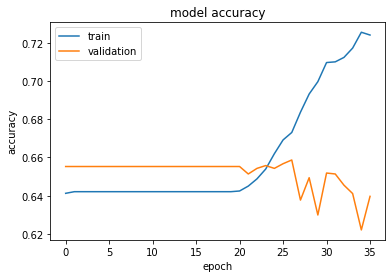

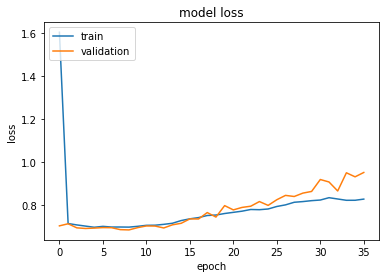

In [ ]:
# plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
# testing the model
y_hat = model.predict(X_test)

40/40 [==============================] - 1s 20ms/step


In [ ]:
# testing accuracy
print("Testing Accuracy")
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

Testing Accuracy


0.6140489344909235

In [ ]:
# Confusion matrix (testing)
confusion_matrix(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)))

#FP: prediction is real(1) but actual is fake
#TN: prediction is fake and actual is fake

array([[713, 105],
       [384,  65]])